# Analyse de la Qualité du Jus : Classification avec SVM et XGBoost

Ce notebook presente une analyse complète pour predire la qualité du jus à partir de ses caracteristiques physico chimiques. Nous allons comparer deux modeles de machine learning : **Kernel SVM** et **XGBoost**, puis selectionner le meilleur pour une utilisation future dans une application Streamlit.

## 1. Importation des Librairies

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

from xgboost import XGBClassifier
import joblib

import warnings
warnings.filterwarnings('ignore')

## 2. Chargement des Données

Chargement du fichier juice.csv qui contient les caracteristiques physico chimiques et la variable cible `quality`.

In [50]:
df = pd.read_csv('juice.csv')
print(f"Dimensions du dataset : {df.shape}")
df.head()

Dimensions du dataset : (4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [52]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


### Verification des doublons

In [53]:
print(f"Doublons : {df.duplicated().sum()}")

# Supression des doublons
df = df.drop_duplicates()
print(f"Dimensions apres suppression : {df.shape}")

Doublons : 937
Dimensions apres suppression : (3961, 12)


## 3. Analyse Exploratoire des Données (EDA)

### Distribution de la variable cible

Analysons comment sont réparties les differentes classes de qualité dans notre dataset.

In [54]:
print(f"Nombre de classes de qualité : {df['quality'].nunique()}")
print(f"\nDistribution des classes :")
print(df['quality'].value_counts().sort_index())

Nombre de classes de qualité : 7

Distribution des classes :
quality
3      20
4     153
5    1175
6    1788
7     689
8     131
9       5
Name: count, dtype: int64


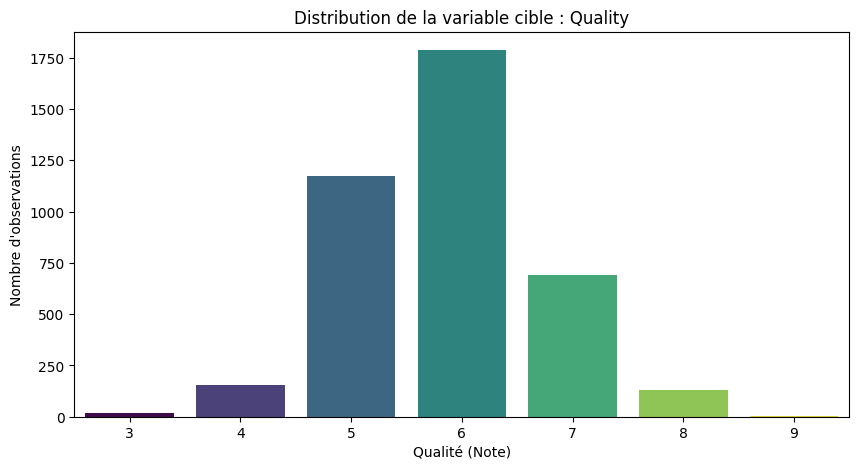

In [55]:
plt.figure(figsize=(10, 5))
sns.countplot(x='quality', data=df, palette='viridis', hue='quality', legend=False)
plt.title('Distribution de la variable cible : Quality')
plt.xlabel('Qualité (Note)')
plt.ylabel("Nombre d'observations")
plt.show()

### Distribution des features par classe de qualité

Visualisons comment chaque variable se distribue en fonction de la classe de qualite. Ca nous permetra de voir quelles features sont discriminantes.

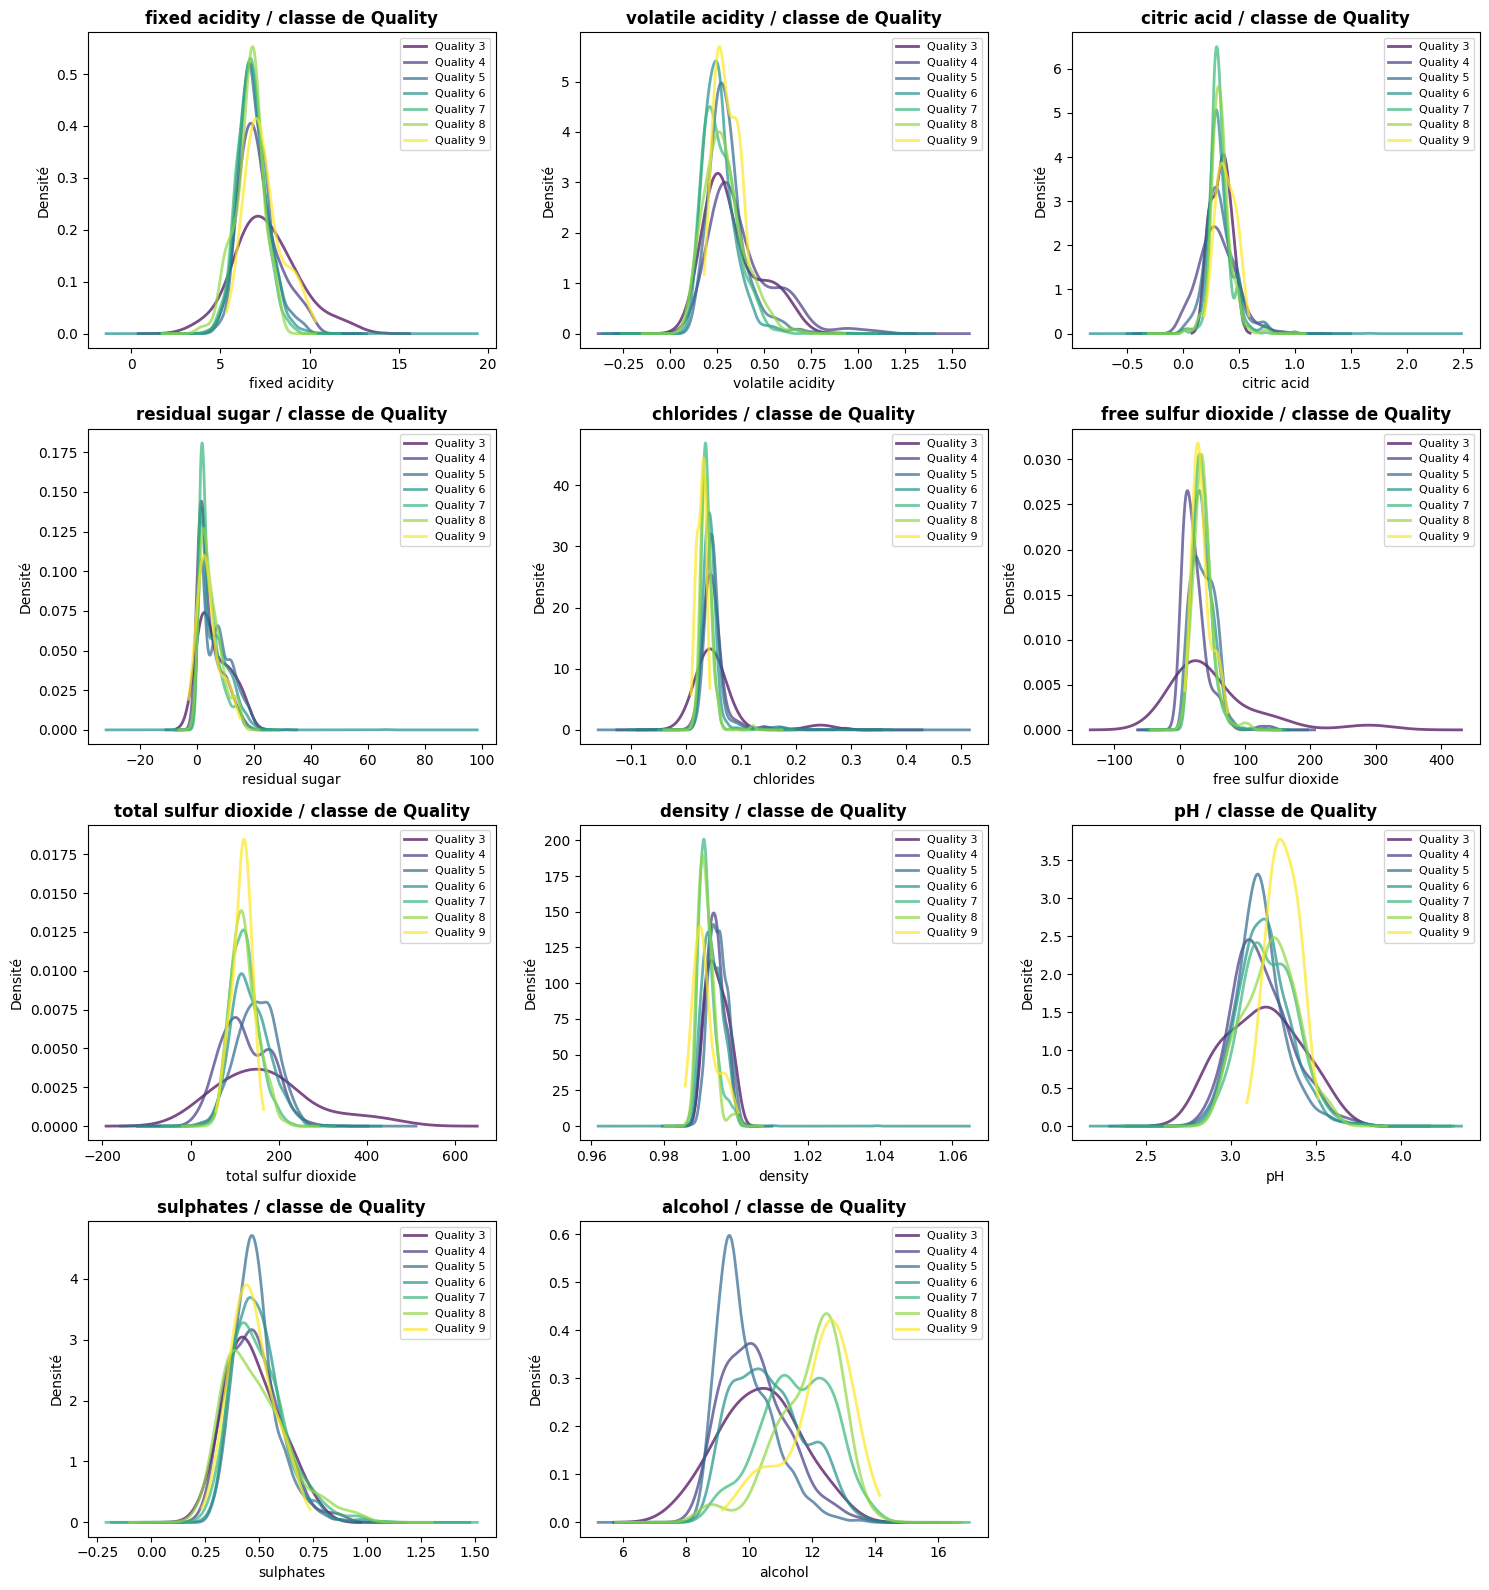

In [56]:
features = df.columns.drop('quality')
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

quality_classes = sorted(df['quality'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(quality_classes)))

for idx, feature in enumerate(features):
    for quality, color in zip(quality_classes, colors):
        df[df['quality'] == quality][feature].plot(
            kind='kde', ax=axes[idx], linewidth=2, 
            label=f'Quality {quality}', color=color, alpha=0.7
        )
    axes[idx].set_title(f'{feature} / classe de Quality', fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Densité')
    axes[idx].legend(loc='best', fontsize=8)

for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Detection des Outliers

On utilise des boxplots normalisés pour visualiser les valeurs aberantes dans chaque variable.

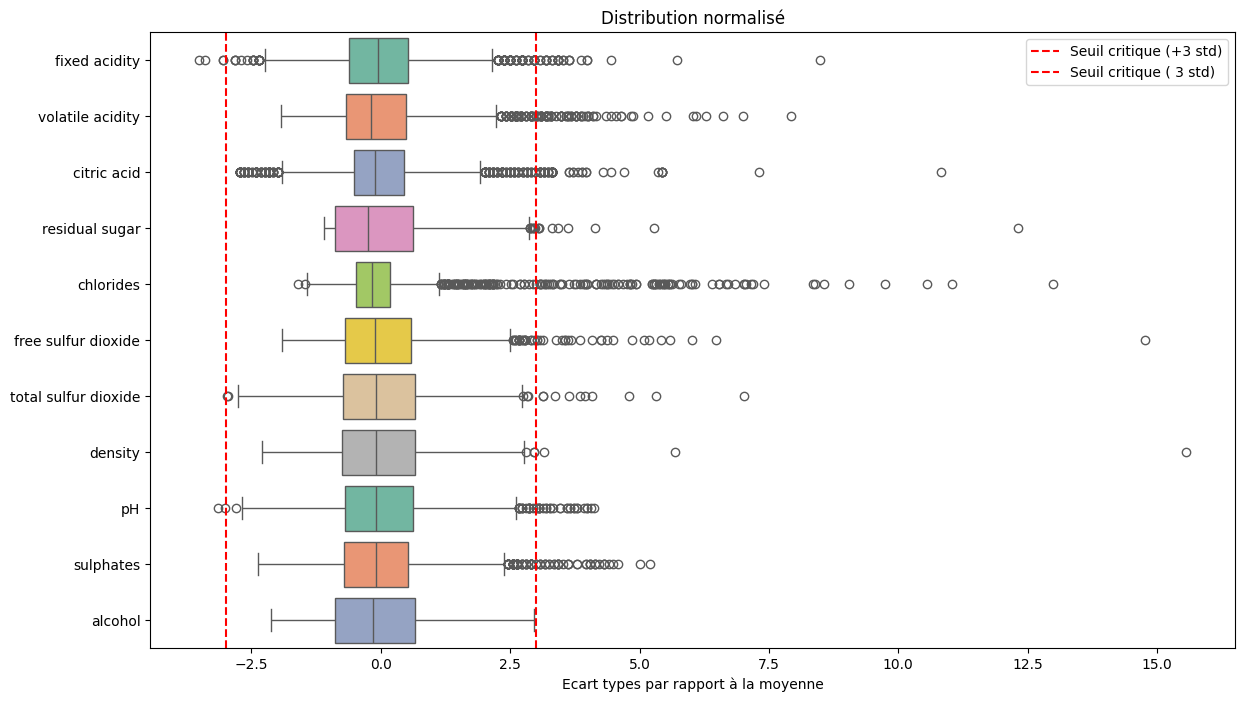

In [57]:
plt.figure(figsize=(14, 8))
df_normalized = (df.drop(columns=['quality']) - df.drop(columns=['quality']).mean()) / df.drop(columns=['quality']).std()
sns.boxplot(data=df_normalized, orient="h", palette="Set2")
plt.title('Distribution normalisé')
plt.xlabel('Ecart types par rapport à la moyenne')
plt.axvline(x=3, color='r', linestyle='--', label='Seuil critique (+3 std)')
plt.axvline(x=-3, color='r', linestyle='--', label='Seuil critique ( 3 std)')
plt.legend()
plt.show()

### Matrice de Corrélation

Etudions les correlations entre les differentes variables pour identifier les relations et potentielles colinéarités.

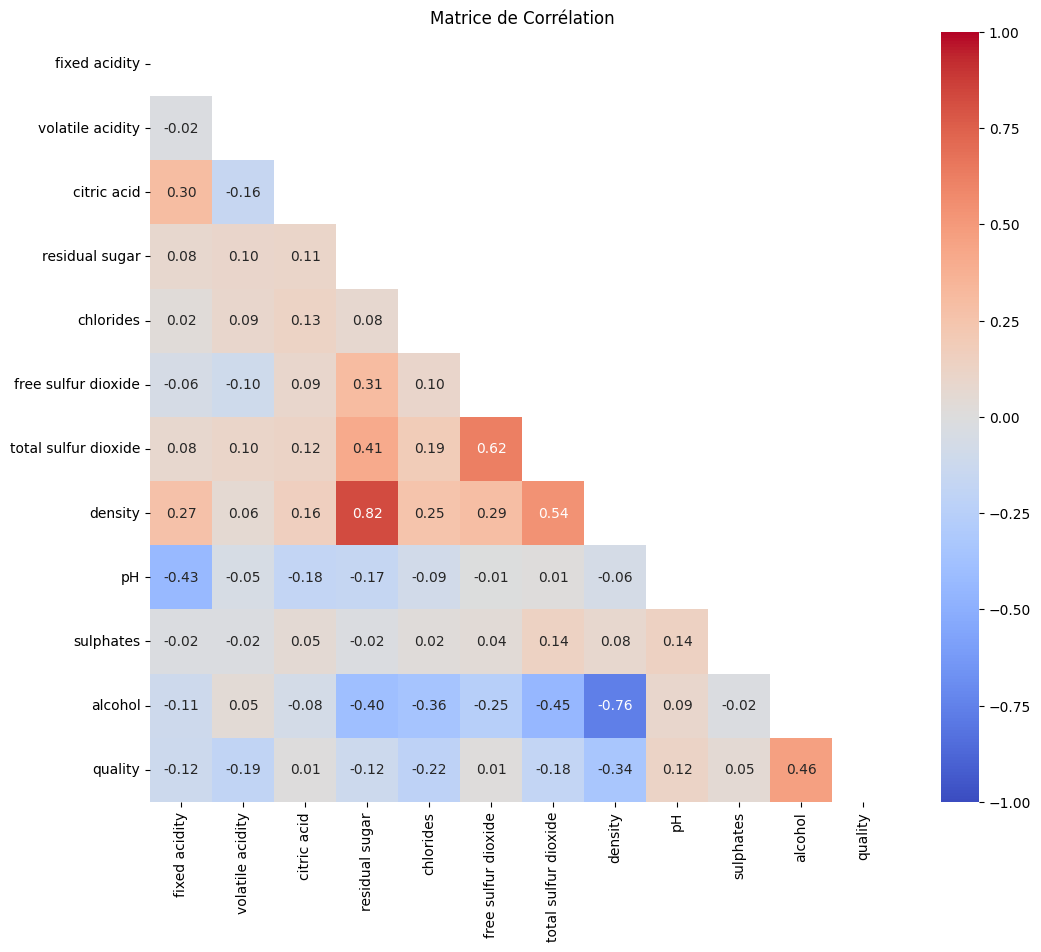

In [58]:
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matrice de Corrélation')
plt.show()

## 4. Prétraitement des Données

### Analyse du VIF (Variance Inflation Factor)

Le VIF nous aide à identifier les variables qui presentent une forte multicolinéarité. On va supprimer les variables problematiques.

In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

data_vif = df.drop(columns=['quality'])

vif_data = pd.DataFrame()
vif_data["Variable"] = data_vif.columns
vif_data["VIF"] = [variance_inflation_factor(data_vif.values, i) for i in range(data_vif.shape[1])]
print("Analyse VIF avant suppression :")
print(vif_data.sort_values('VIF', ascending=False))

Analyse VIF avant suppression :
                Variable          VIF
7                density  1049.318317
8                     pH   606.325839
10               alcohol   116.792244
0          fixed acidity    88.572299
6   total sulfur dioxide    24.538845
9              sulphates    20.700587
2            citric acid    10.033242
1       volatile acidity     9.672963
5    free sulfur dioxide     9.130488
4              chlorides     5.989047
3         residual sugar     3.511738


### Suppression des variables problematiques

Suite a l'analyse VIF et aux tests statistiques, on supprime les colonnes `sulphates`, `citric acid` et `density` qui presentent des problemes de multicolinéarité ou de significativité.

In [60]:
# Suppression des colonnes problematiques
cols_to_drop = ['sulphates', 'citric acid', 'density']
df_clean = df.drop(columns=cols_to_drop)

print(f"Colonnes supprimées : {cols_to_drop}")
print(f"Nouvelles dimensions : {df_clean.shape}")
print(f"Colonnes restantes : {list(df_clean.columns)}")

Colonnes supprimées : ['sulphates', 'citric acid', 'density']
Nouvelles dimensions : (3961, 9)
Colonnes restantes : ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'alcohol', 'quality']


In [61]:
# Verification du nouveau VIF
data_vif_clean = df_clean.drop(columns=['quality'])

vif_clean = pd.DataFrame()
vif_clean["Variable"] = data_vif_clean.columns
vif_clean["VIF"] = [variance_inflation_factor(data_vif_clean.values, i) for i in range(data_vif_clean.shape[1])]
print("Analyse VIF apres suppression :")
print(vif_clean.sort_values('VIF', ascending=False))

Analyse VIF apres suppression :
               Variable         VIF
6                    pH  142.032141
7               alcohol  100.780096
0         fixed acidity   49.793044
5  total sulfur dioxide   23.891850
1      volatile acidity    9.222474
4   free sulfur dioxide    9.007263
3             chlorides    5.499855
2        residual sugar    3.221570


### Separation Features / Target et Encodage

On separe les features de la variable cible et on encode les classes de qualité avec un LabelEncoder pour pouvoir les utiliser.

In [62]:
X = df_clean.drop('quality', axis=1)
y = df_clean['quality']

print(f"Features (X) : {X.shape}")
print(f"Target (y) : {y.shape}")

Features (X) : (3961, 8)
Target (y) : (3961,)


In [63]:
# Encodage de la variable cible
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Classes originales : {le.classes_}")
print(f"Classes encodées : {np.unique(y_encoded)}")

Classes originales : [3 4 5 6 7 8 9]
Classes encodées : [0 1 2 3 4 5 6]


### Split Train/Test

On divise les données en 80% pour l'entrainement et 20% pour le test. On utilise la stratification afin de garder la meme proportion de classes dans les deux groupes.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Train set : {X_train.shape[0]} echantillons")
print(f"Test set : {X_test.shape[0]} echantillons")

Train set : 3168 echantillons
Test set : 793 echantillons


## 5. Scaling des Données

On utilise le RobustScaler qui est plus resistant aux outliers que le StandardScaler. Il utilise la mediane et l'IQR plutot que la moyenne et l'ecart type.

In [65]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Moyenne X_train_scaled : {X_train_scaled.mean():.4f}")
print(f"Std X_train_scaled : {X_train_scaled.std():.4f}")

Moyenne X_train_scaled : 0.1261
Std X_train_scaled : 0.9230


## 6. Entrainement des Modèles

Nous allons maintennant entrainer nos deux modeles : **Kernel SVM** et **XGBoost**. Pour chaque modele, on utilise GridSearchCV pour trouver les meilleurs hyperparametres.

### Modèle 1 : Kernel SVM (Support Vector Machine)

On utilise `class_weight='balanced'` pour gerer le desequilibre des classes.

In [66]:
svm = SVC(
    kernel='rbf', 
    class_weight='balanced', 
    probability=True, 
    random_state=42
)

# Grille d'hyperparametres
param_grid_svm = {
    'C': [1, 10, 100], 
    'gamma': ['scale', 0.1, 0.01]
}

grid_svm = GridSearchCV(
    svm, 
    param_grid_svm, 
    cv=3, 
    scoring='f1_weighted', 
    n_jobs=-1,
    verbose=1
)
grid_svm.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


,estimator,SVC(class_wei...ndom_state=42)
,param_grid,"{'C': [1, 10, ...], 'gamma': ['scale', 0.1, ...]}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,100


In [67]:
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)

print(f"Meilleurs parametres SVM : {grid_svm.best_params_}")
print(f"Meilleur score CV : {grid_svm.best_score_:.4f}")

Meilleurs parametres SVM : {'C': 100, 'gamma': 'scale'}
Meilleur score CV : 0.4299


In [68]:
# Resultats SVM
print(f"Accuracy : {accuracy_score(y_test, y_pred_svm):.4f}")
print(classification_report(y_test, y_pred_svm, target_names=[str(c) for c in le.classes_], zero_division=0))

Accuracy : 0.4262
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.15      0.26      0.19        31
           5       0.53      0.57      0.55       235
           6       0.54      0.35      0.43       358
           7       0.34      0.44      0.38       138
           8       0.13      0.35      0.19        26
           9       0.00      0.00      0.00         1

    accuracy                           0.43       793
   macro avg       0.24      0.28      0.25       793
weighted avg       0.47      0.43      0.43       793



### Modèle 2 : XGBoost Classifier

XGBoost est un algorithme de gradient boosting tres performant. On utilise l'objectif `multi:softprob` pour la classification multiclasse.

In [69]:
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Grille d'hyperparametres
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

print("Recherche des meilleurs hyperparametres pour XGBoost...")
grid_xgb = GridSearchCV(
    xgb, 
    param_grid_xgb, 
    cv=3, 
    scoring='f1_weighted', 
    n_jobs=-1,
    verbose=1
)
grid_xgb.fit(X_train_scaled, y_train)

Recherche des meilleurs hyperparametres pour XGBoost...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


,estimator,"XGBClassifier..._class=7, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 6, ...], 'n_estimators': [100, 200]}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [70]:
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)

print(f"Meilleurs parametres XGBoost : {grid_xgb.best_params_}")
print(f"Meilleur score CV : {grid_xgb.best_score_:.4f}")

Meilleurs parametres XGBoost : {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200}
Meilleur score CV : 0.5216


In [71]:
# Resultats XGBoost
print(f"Accuracy : {accuracy_score(y_test, y_pred_xgb):.4f}")
print(classification_report(y_test, y_pred_xgb, target_names=[str(c) for c in le.classes_], zero_division=0))

Accuracy : 0.5309
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.31      0.16      0.21        31
           5       0.55      0.55      0.55       235
           6       0.55      0.68      0.61       358
           7       0.46      0.33      0.38       138
           8       0.00      0.00      0.00        26
           9       0.00      0.00      0.00         1

    accuracy                           0.53       793
   macro avg       0.27      0.24      0.25       793
weighted avg       0.50      0.53      0.51       793



## 7. Comparaison et Selection du Meilleur Modèle

On compare les deux modeles en utilisant le **F1 Score Weighted** comme metrique principale. C'est une bonne metrique pour les problemes de classification multiclasse avec des classes desequilibrées.

In [72]:
# Calcul des F1 Scores
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

acc_svm = accuracy_score(y_test, y_pred_svm)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"\n{'Metrique':<20} {'SVM':<15} {'XGBoost':<15}")
print(f"{'Accuracy':<20} {acc_svm:<15.4f} {acc_xgb:<15.4f}")
print(f"{'F1 Score Weighted':<20} {f1_svm:<15.4f} {f1_xgb:<15.4f}")


Metrique             SVM             XGBoost        
Accuracy             0.4262          0.5309         
F1 Score Weighted    0.4349          0.5114         


### Visualisation : Matrices de Confusion

Comparons visuellement les performances des deux modeles avec leurs matrices de confusion.

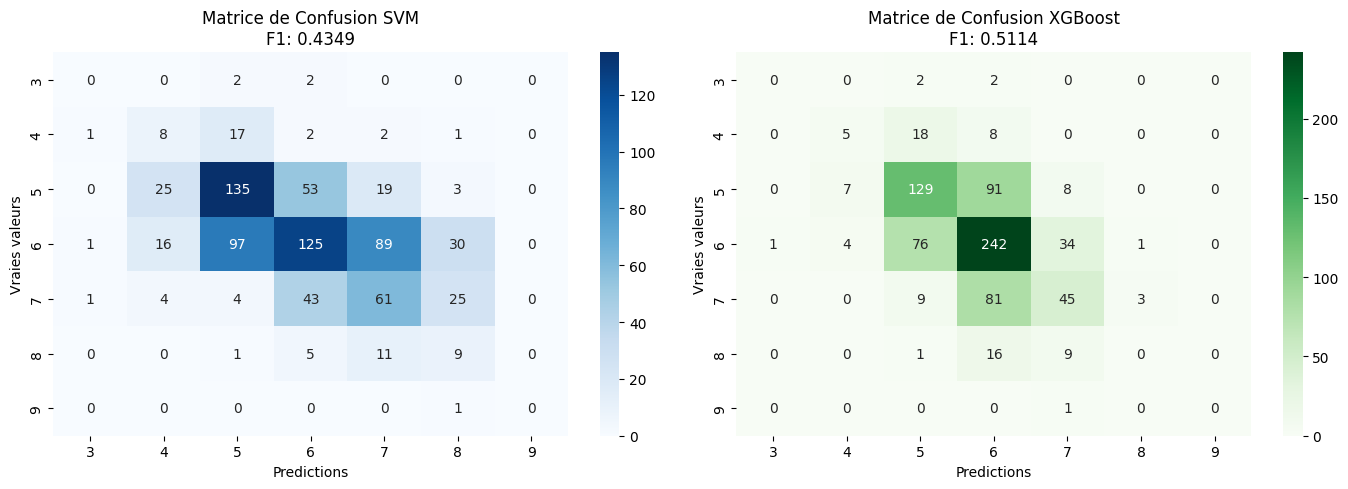

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matrice de confusion SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[0].set_title(f'Matrice de Confusion SVM\nF1: {f1_svm:.4f}')
axes[0].set_xlabel('Predictions')
axes[0].set_ylabel('Vraies valeurs')

# Matrice de confusion XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[1].set_title(f'Matrice de Confusion XGBoost\nF1: {f1_xgb:.4f}')
axes[1].set_xlabel('Predictions')
axes[1].set_ylabel('Vraies valeurs')

plt.tight_layout()
plt.show()

### Visualisation : Comparaison des Scores

Graphique comparatif des performances des deux modeles.

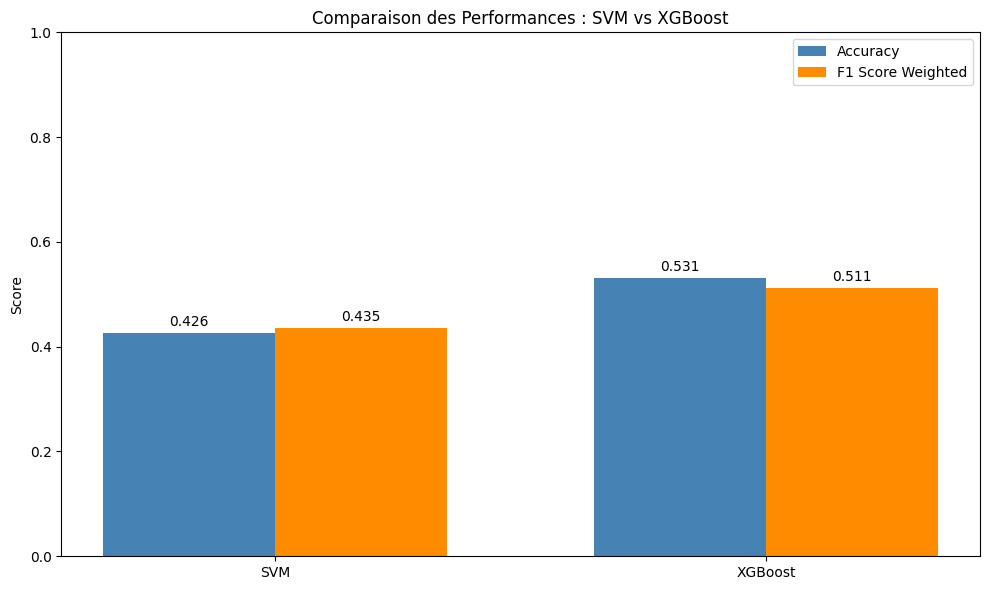

In [74]:
models = ['SVM', 'XGBoost']
accuracy_scores = [acc_svm, acc_xgb]
f1_scores = [f1_svm, f1_xgb]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy', color='steelblue')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score Weighted', color='darkorange')

ax.set_ylabel('Score')
ax.set_title('Comparaison des Performances : SVM vs XGBoost')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1)

for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Validation Croisée du Modèle Final

On effectue une validation croisee 5 fold sur le modele final pour confirmer sa robustesse.

In [75]:
# Validation croisée sur tout le dataset
cv_scores = cross_val_score(final_model, X_train_scaled, y_train, cv=5, scoring='f1_weighted')

print(f"Validation Croisee 5 Fold pour {model_name}")
print(f"Scores par fold : {cv_scores}")
print(f"Moyenne : {cv_scores.mean():.4f}")
print(f"Ecart type : {cv_scores.std():.4f}")

Validation Croisee 5 Fold pour XGBoost
Scores par fold : [0.50080612 0.52639231 0.49561142 0.53784432 0.51411521]
Moyenne : 0.5150
Ecart type : 0.0157


## 8. Export du Modèle Final

In [76]:
# Creation du dictionnaire avec tous les artefacts
artifacts = {
    'model': final_model,
    'scaler': scaler,
    'encoder': le,
    'model_name': model_name,
    'feature_names': list(X.columns),
    'classes': list(le.classes_)
}

# Sauvegarde avec joblib
joblib.dump(artifacts, 'best_model_juice.pkl')

['best_model_juice.pkl']

### Verification de la sauvegarde

In [77]:
loaded_artifacts = joblib.load('best_model_juice.pkl')

print(f"Modele : {loaded_artifacts['model_name']}")
print(f"Features : {loaded_artifacts['feature_names']}")
print(f"Classes : {loaded_artifacts['classes']}")

Modele : XGBoost
Features : ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'alcohol']
Classes : [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
